In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import pprint
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
img_size = 256  # Reduce image size to lower memory usage

In [37]:
def load_and_process_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0)
    print(img.shape)
    return img

def deprocess_image(processed_img):
    transform = transforms.Compose([
        transforms.Normalize(mean=[-2.118, -2.036, -1.804], std=[4.367, 4.464, 4.444]),
        transforms.Lambda(lambda x: x.div(255)),
        transforms.Lambda(lambda x: x.clamp(0, 1)),
        transforms.ToPILImage(),
    ])
    img = processed_img.squeeze(0)
    img = transform(img)
    return img

def gram_matrix(A):
    A = A.squeeze()
    GA = torch.mm(A, A.t())
    return GA


def compute_layer_style_cost(style_output, generated_output):
    a_S = style_output
    a_G = generated_output
    
    assert len(a_S.size()) == 4, f"Style output tensor must have 4 dimensions, but got {a_S.size()}"
    assert len(a_G.size()) == 4, f"Generated output tensor must have 4 dimensions, but got {a_G.size()}"
    
    _, n_C, n_H, n_W = a_G.size()
    
    a_S = a_S.reshape(-1, n_C).transpose(0, 1)
    # OR a_S = a_S.reshape(n_H * n_W, n_C).transpose(0, 1)
    a_G = a_G.reshape(-1, n_C).transpose(0, 1)

    # print(f"As shape is {a_S.shape}")
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = torch.sum((GS - GG) ** 2) / (4.0 * (n_C ** 2) * ((n_H * n_W) ** 2))
    
    return J_style_layer

def compute_style_cost(style_image_output, generated_image_output, style_layers, style_weights):
    J_style = 0
    for layer_name, coeff in style_weights.items():
        out_style = style_image_output[layer_name]
        out_generated = generated_image_output[layer_name]

        assert len(out_style.size()) == 4, f"Style output tensor for {layer_name} must have 4 dimensions, but got {out_style.size()}"
        assert len(out_generated.size()) == 4, f"Generated output tensor for {layer_name} must have 4 dimensions, but got {out_generated.size()}"
        
        J_style_layer = compute_layer_style_cost(out_style, out_generated)
        J_style += coeff * J_style_layer
    
    return J_style


def compute_content_cost(content_output, generated_output):
    a_C = content_output
    a_G = generated_output
    
    _, n_C, n_H, n_W = a_G.size()
    
    
    J_content = torch.sum((a_C - a_G) ** 2) / (4.0 * n_C * n_H * n_W)
    
    return J_content

def total_cost(J_content, J_style, alpha=10, beta=40):
    J = alpha * J_content + beta * J_style
    return J


In [38]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg_layers = models.vgg19(pretrained=True).features
        self.layer_name_mapping = {
            '0': "conv1_1",
            '5': "conv2_1",
            '10': "conv3_1",
            '19': "conv4_1",
            '21': "conv4_2",  # Content layer
            '28': "conv5_1"
        }
    
    def forward(self, x):
        output = {}
        for name, layer in self.vgg_layers._modules.items():
            x = layer(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return output

vgg = VGG().to(device).eval()


/home/swodesh/Documents/swodesh-2001/swodesh/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/swodesh/Documents/swodesh-2001/swodesh/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:

# Load images
content_image = load_and_process_image("images/content.jpg").to(device)
style_image = load_and_process_image("images/style.jpg").to(device)
generated_image = content_image.clone().requires_grad_(True).to(device)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [40]:
content_layers = ["conv4_2"]
# Example values for style_layers and style_weights
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.8,
    'conv3_1': 0.5,
    'conv4_1': 0.3,
    'conv5_1': 0.1,
}

Iteration 0: Total Cost = 570317930496.0


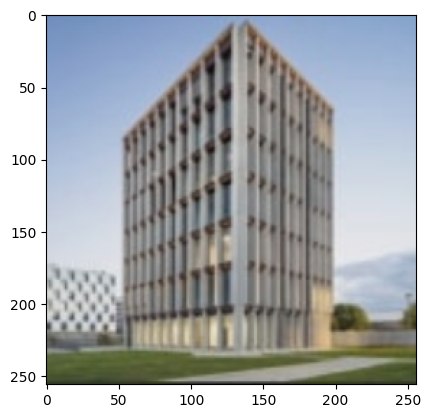

Iteration 20: Total Cost = 561381179392.0


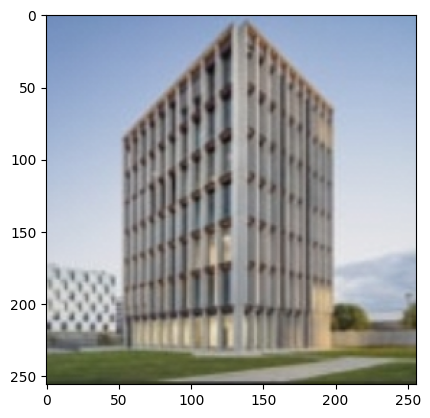

Iteration 40: Total Cost = 552660238336.0


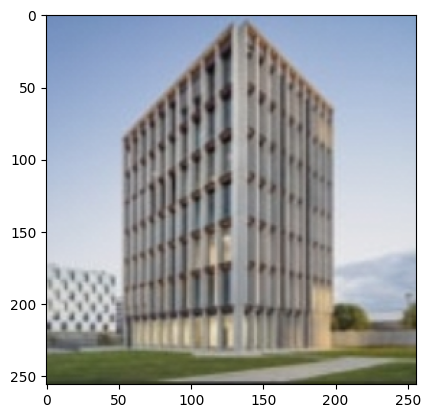

Iteration 60: Total Cost = 544128761856.0


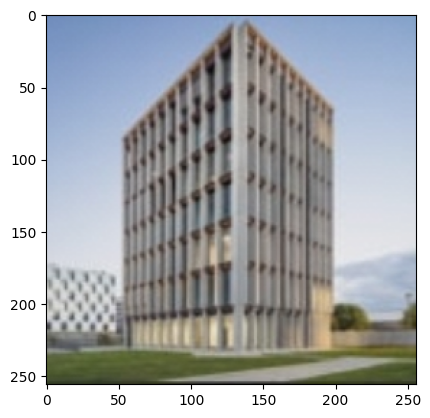

Iteration 80: Total Cost = 535800872960.0


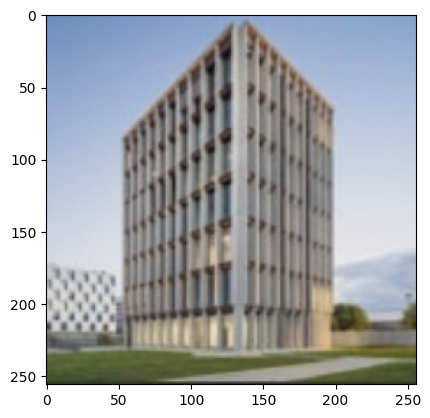

Iteration 100: Total Cost = 527709569024.0


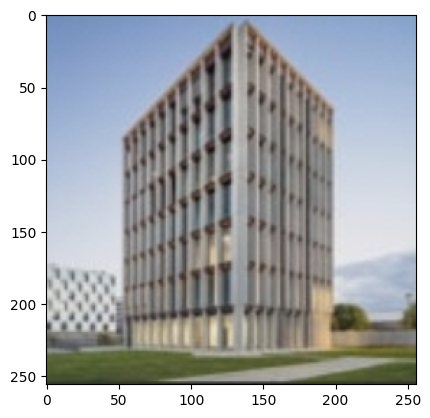

Iteration 120: Total Cost = 519848460288.0


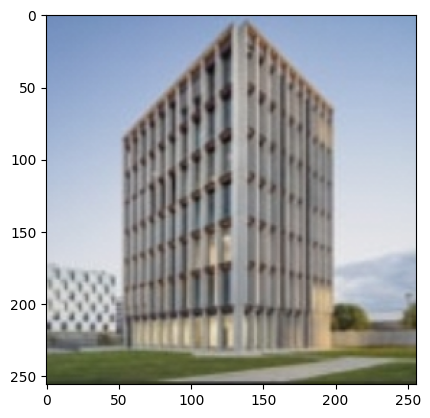

Iteration 140: Total Cost = 512211288064.0


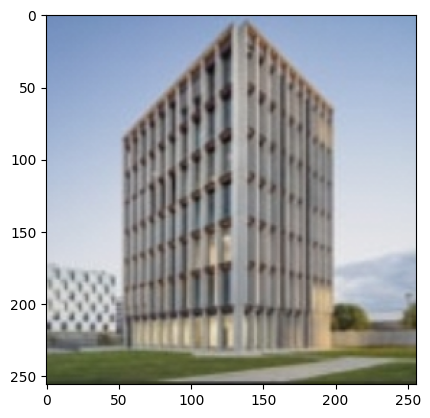

Iteration 160: Total Cost = 504797986816.0


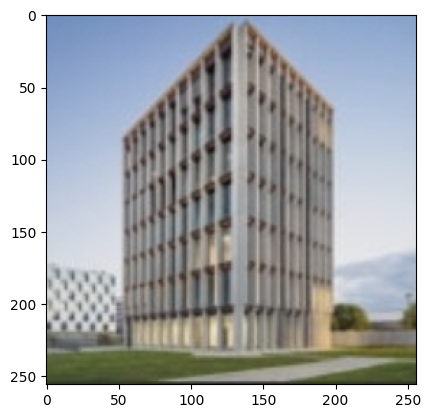

Iteration 180: Total Cost = 497593155584.0


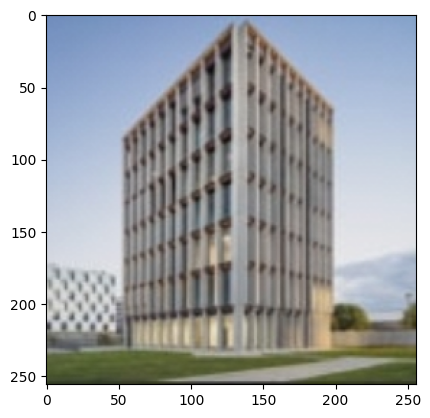

In [41]:

# Extract features
content_features = vgg(content_image)["conv4_2"]
style_features = {layer: vgg(style_image)[layer] for layer in style_layers}

# Optimizer
optimizer = optim.Adam([generated_image], lr=0.01)

# Training
for i in range(200):
    optimizer.zero_grad()
    generated_features = vgg(generated_image)
    content_output = generated_features["conv4_2"]
    style_output = {layer: generated_features[layer] for layer in style_layers}
    
    J_content = compute_content_cost(content_features, content_output)
    J_style = compute_style_cost(style_features, style_output, style_layers, style_weights)
    J_total = total_cost(J_content, J_style)
    
    J_total.backward(retain_graph= True)
    optimizer.step()
    
    if i % 20 == 0:
        print(f"Iteration {i}: Total Cost = {J_total.item()}")
        image = deprocess_image(generated_image.detach())
        plt.imshow(image)
        plt.show()